<a href="https://colab.research.google.com/github/dmcguire81/metapy/blob/master/tutorials/sigir18-topic-models/sigir18-topic-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
# NOTE: this assumes you've uploaded a Python 3.7 build from our fork to Drive
# TODO: replace this with a stock install when it's published somewhere
%pip install /content/drive/MyDrive/metapy-0.2.13-cp37-cp37m-manylinux_2_24_x86_64.whl

# Exercise 2: Topic Model Inference in LDA

First, let's import the Python bindings for MeTA:

In [3]:
import metapy

If you don't have `metapy` installed, you can install it with a

```bash
pip install metapy
```

on the command line on Linux, macOS, or Windows for either Python 2.7 or Python 3.x. (I will be using Python 3.6 in this tutorial.)

Double-check that you are running the latest version. Right now, that should be `0.2.10`.

In [4]:
metapy.__version__

'0.2.13'

Now, let's set MeTA to log to standard error so we can see progress output for long-running commands. (Only do this once, or you'll get double the output.)

In [5]:
metapy.log_to_stderr()

Now, let's download all of the files we need for the tutorial.

In [6]:
import urllib.request
import os
import tarfile

if not os.path.exists('sigir18-tutorial.tar.gz'):
    urllib.request.urlretrieve('https://meta-toolkit.org/data/2018-06-25/sigir18-tutorial.tar.gz',
                               'sigir18-tutorial.tar.gz')
    
if not os.path.exists('data'):
    with tarfile.open('sigir18-tutorial.tar.gz', 'r:gz') as files:
        files.extractall()

The tutorial files come with a dataset consisting of four years of NIPS proceedings (full text): 2002, 2007, 2012, and 2017.

To start, we first want to understand what topics are being discussed in NIPS in these for years. To do that, we'll first index the dataset in the `ForwardIndex` format (we want to map documents to the terms that they contain).

In [7]:
fidx = metapy.index.make_forward_index('nips.toml')

1669329955: [info]     Loading index from disk: nips-idx/fwd (/metapy/deps/meta/src/index/forward_index.cpp:171)


Now, let's load in all of the documents into memory so we can start to infer a topic model. I'm going to load them in as a `MulticlassDataset` because each document here has been associated with a label (the year it came from), but you could also load them in as just a standard `Dataset` with no associated labels if you don't plan to use them.

In [8]:
dset = metapy.classify.MulticlassDataset(fidx)

 > Loading instances into memory: [==========================] 100% ETA 00:00:00 


With the documents loaded into memory, we can start to run LDA inference on them to infer the topics and their coverage in each of the documents. There are several choices for inference algorithm in MeTA, so in general you can just pick your favorite. Here, I'm going to pick a parallelized version of Gibbs sampling.

The below will run the sampler for either 1000 iterations or until the log likelihood ($\log P(W \mid Z)$) stabilizes, whichever comes first. (If you want to disable the convergence checking and just run the sampler for a fixed number of iterations, you can add the parameter `convergence=0`.)

In [9]:
model = metapy.topics.LDAParallelGibbs(docs=dset, num_topics=10, alpha=0.1, beta=0.1)
model.run(num_iters=1000)
model.save('lda-pgibbs-nips')

Initialization log likelihood (log P(W|Z)): -2.96264e+07                        
Iteration 1 log likelihood (log P(W|Z)): -2.96823e+07                           
Iteration 2 log likelihood (log P(W|Z)): -2.96265e+07                           
Iteration 3 log likelihood (log P(W|Z)): -2.95512e+07                           
Iteration 4 log likelihood (log P(W|Z)): -2.9484e+07                            
Iteration 5 log likelihood (log P(W|Z)): -2.94257e+07                           
Iteration 6 log likelihood (log P(W|Z)): -2.93769e+07                           
Iteration 7 log likelihood (log P(W|Z)): -2.9339e+07                            
Iteration 8 log likelihood (log P(W|Z)): -2.93059e+07                           
Iteration 9 log likelihood (log P(W|Z)): -2.9279e+07                            
Iteration 10 log likelihood (log P(W|Z)): -2.92582e+07                          
Iteration 11 log likelihood (log P(W|Z)): -2.92408e+07                          
Iteration 12 log likelihood 

Once the above converges, it will save the results to disk. We can load the results into memory for inspection by loading an instance of the `TopicModel` class:

In [10]:
model = metapy.topics.TopicModel('lda-pgibbs-nips')

 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 
 > Loading document topic probabilities: [===================] 100% ETA 00:00:00 


What do the topics discussed in NIPS over the last two decades roughly look like?

In [11]:
for topic in range(0, model.num_topics()):
    print("Topic {}:".format(topic + 1))
    for tid, val in model.top_k(topic, 10, metapy.topics.BLTermScorer(model)):
        print("{}: {}".format(fidx.term_text(tid), val))
    print("======\n")

Topic 1:
graph: 0.07794372668594803
cluster: 0.07746281130821964
node: 0.06660449791680528
tree: 0.046811849834217656
edg: 0.03787754476381001
item: 0.02583362969509939
rank: 0.022967405120162737
network: 0.020726330547872585
user: 0.01802240094020531
algorithm: 0.0168518732012809

Topic 2:
regret: 0.0747529357995842
bound: 0.05513522752425951
algorithm: 0.03577688478711116
arm: 0.03288612365565613
theorem: 0.03144019251342573
loss: 0.030159243011213997
bandit: 0.030034863847701987
xt: 0.027218876233834344
risk: 0.022220872237854294
log: 0.02025384585044621

Topic 3:
polici: 0.18189258099030417
reward: 0.08658706459349955
action: 0.08606145127729259
agent: 0.0821259788985647
state: 0.05227596191446082
game: 0.04510842398503497
reinforc: 0.036648880602731644
trajectori: 0.032022385392139974
mdp: 0.023372774832108312
episod: 0.021056022170335222

Topic 4:
matrix: 0.04817594980468609
convex: 0.042768636420995314
norm: 0.02167220817331588
theorem: 0.020695821791635892
converg: 0.0201119718

# Exercise 3: Text Mining using Topic Models

## Topics over Time

An interesting "mining" question to ask on top of this is whether or not the topics used in NIPS have changed over time. Are certain topics exhibited only in the earlier years, or vice-versa?

To do this, let's take a look at the other output of LDA---the topic proportion vectors associated with each document. Since each document also has a label in our dataset, we can create plots for each topic to see the number of documents that mention a specific topic in a specific year, and to what degree.

We'll start by creating a simple dataset with `pandas`:

In [12]:
import pandas as pd

data = []
for doc in dset:
    proportions = model.topic_distribution(doc.id)
    data.append([dset.label(doc)] + [proportions.probability(i) for i in range(0, model.num_topics())])
df = pd.DataFrame(data, columns=['label'] + ["Topic {}".format(i + 1) for i in range(0, model.num_topics())])

Now, let's plot the results. There a lot of ways to do this, but here I'm going to use a "swarm plot" so we can see where each and every document falls.

Topic 1


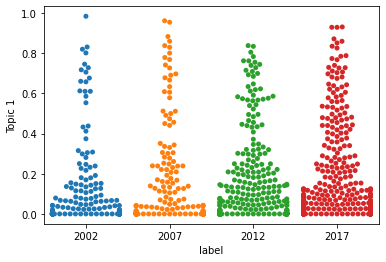

Topic 2


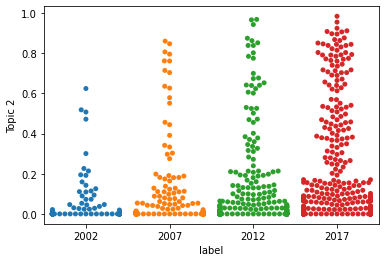

Topic 3


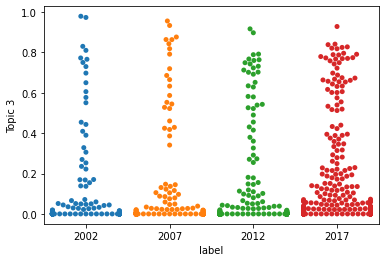

Topic 4


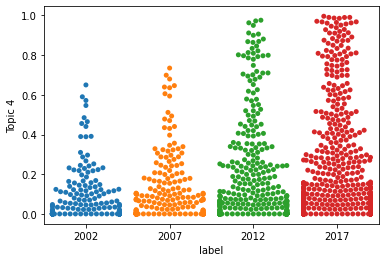

Topic 5


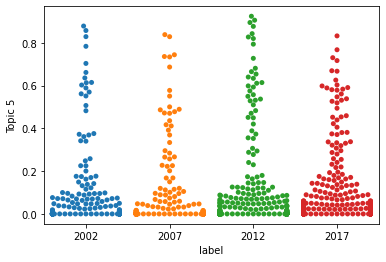

Topic 6


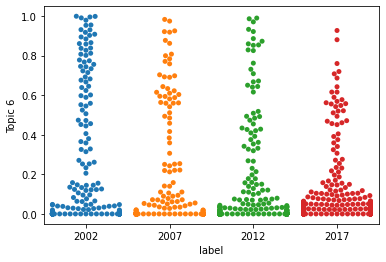

Topic 7


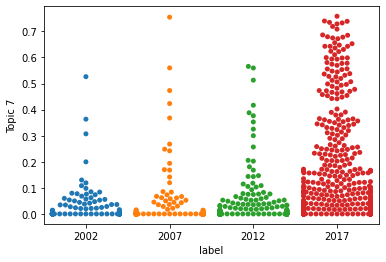

Topic 8


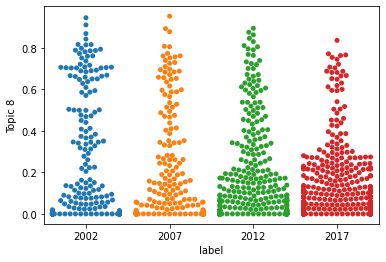

Topic 9


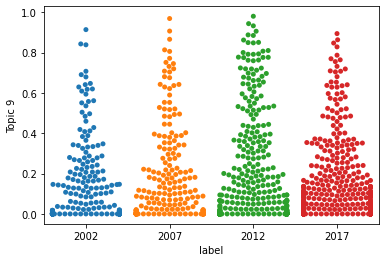

Topic 10


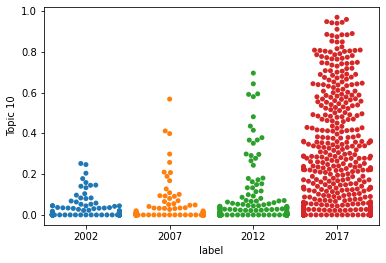

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# otherwise, seaborn is very noisy
warnings.simplefilter('ignore', category=UserWarning)

for i in range(0, model.num_topics()):
    print("Topic {}".format(i + 1))
    sns.swarmplot(data=df, x='label', y="Topic {}".format(i + 1))
    plt.show()

## Topic Inference (Unseen Document)

Let's try to figure out what topics are mentioned in a previously unseen document.

In [14]:
%%capture
!wget -N https://raw.githubusercontent.com/dmcguire81/metapy/master/tutorials/sigir18-topic-models/6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt

In [15]:
doc = metapy.index.Document()
with open('6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt') as f:
    doc.content(f.read())
print("{}...".format(doc.content()[0:500]))

Scan Order in Gibbs Sampling: Models in Which it
Matters and Bounds on How Much
Bryan He, Christopher De Sa, Ioannis Mitliagkas, and Christopher Ré
Stanford University
{bryanhe,cdesa,imit,chrismre}@stanford.edu
Abstract
Gibbs sampling is a Markov Chain Monte Carlo sampling technique that iteratively
samples variables from their conditional distributions. There are two common scan
orders for the variables: random scan and systematic scan. Due to the benefits
of locality in hardware, systematic sc...


We first need to transform the unseen document into the same term-id space used by the topic model.

In [16]:
dvec = fidx.tokenize(doc)

...and then we can create an inferencer on top of our topic model output to infer the topic coverage for this new document:

In [17]:
inferencer = metapy.topics.GibbsInferencer('lda-pgibbs-nips.phi.bin', alpha=0.1)
props = inferencer.infer(dvec, max_iters=100, rng_seed=42)
print(props)

<metapy.stats.Multinomial {0: 0.145556, 1: 0.001111, 2: 0.178889, 3: 0.101111, 4: 0.190000, 5: 0.001111, 6: 0.001111, 7: 0.001111, 8: 0.367778, 9: 0.012222}>


 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 


## Classification with Topic Features

The topic proportion vectors are also often used as input to a classifier. In our case, since we see some differences between the years 2002 and 2017 in terms of topical coverage, let's see if we can learn to separate documents that were written in 2002 from documents that were written in 2017 on the basis of their topic proportions alone.

In [18]:
# First, create a lightweight view for shuffling
shuffled_view = metapy.classify.MulticlassDatasetView(dset)
shuffled_view.shuffle()

# this dataset will use unigram words as features
words_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    dset.total_features(),
    lambda doc: metapy.learn.FeatureVector(doc.weights),
    lambda doc: dset.label(doc)
)

# this dataset will use topic proportions as features
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

We'll use a 50/50 training/test split setup.

In [19]:
words_train = words_dset[0:int(len(words_dset)/2)]
words_test = words_dset[int(len(words_dset)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [20]:
def make_linear_svm(training):
    return metapy.classify.OneVsAll(training, metapy.classify.SGD, loss_id='hinge')

words_sgd = make_linear_svm(words_train)
topics_sgd = make_linear_svm(topics_train)

print("Words:")
mtrx = words_sgd.test(words_test)
print(mtrx)
mtrx.print_stats()

print("======")
print("Topics:")
mtrx = topics_sgd.test(topics_test)
print(mtrx)
mtrx.print_stats()

Words:

           2002     2017     
         ------------------
    2002 | 0.938    0.0619   
    2017 | 0.0318   0.968    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.915       0.892       0.938       0.219       
2017        0.975       0.982       0.968       0.781       
------------------------------------------------------------
Total       0.962       0.963       0.962       
------------------------------------------------------------
443 predictions attempted, overall accuracy: 0.962

Topics:

           2002     2017     
         ------------------
    2002 | 0.598    0.402    
    2017 | 0.0578   0.942    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.663       0.744   

While we don't beat unigram words, we still do very well for a model that is only using 10 features compared to the tens of thousands used by the words model:

In [21]:
fidx.unique_terms()

66479

We can also try a straight multiclass classification problem: given a document, predect the year from the topic proportions alone.

In [22]:
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

words_train = shuffled_view[0:int(len(shuffled_view)/2)]
words_test = shuffled_view[int(len(shuffled_view)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [23]:
words_svm = make_linear_svm(words_train)
topics_svm = make_linear_svm(topics_train)

words_mtrx = words_svm.test(words_test)
topics_mtrx = topics_svm.test(topics_test)

print("Words:")
print(words_mtrx)
words_mtrx.print_stats()

print("========")
print("Topics:")
print(topics_mtrx)
topics_mtrx.print_stats()

Words:

           2002     2007     2012     2017     
         ------------------------------------
    2002 | 0.75     0.198    0.0417   0.0104   
    2007 | 0.368    0.33     0.226    0.0755   
    2012 | 0.105    0.147    0.524    0.225    
    2017 | 0.00875  0.00875  0.0612   0.921    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.626       0.537       0.75        0.13        
2007        0.366       0.412       0.33        0.144       
2012        0.588       0.671       0.524       0.26        
2017        0.889       0.859       0.921       0.466       
------------------------------------------------------------
Total       0.707       0.704       0.711       
------------------------------------------------------------
736 predictions attempted, overall accuracy: 0.711

Topics:

           2002     2007     2012     2017   

This is quite a bit harder!